In [1]:
from mae_train import SceneMaskAutoEncoder
import torch

model = SceneMaskAutoEncoder.load_from_checkpoint('lightning_logs/SceneMAE/version_4/checkpoints/last.ckpt', map_location = torch.device("cuda"))
# model = SceneMaskAutoEncoder.load_from_checkpoint('lightning_logs/SceneMAE/version_5/checkpoints/epoch=9-val_loss=0.0358390845.ckpt', map_location = torch.device("cuda"))

/home/juexin_zhang/miniconda3/lib/python3.12/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/juexin_zhang/miniconda3/lib/python3.12/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/juexin_zhang/miniconda3/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.2, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(


In [2]:
from NViST.dataLoader.ray_dataset import MVImgNetNeRF as nerf_dataset

dataset = nerf_dataset('./data/', split = 'train', number_of_imgs_from_the_same_scene = 16, patch_hw = [16, 10], return_as_patches = False)

In [3]:
item = dataset.__getitem__(29)
imgs = item['images'].permute(0, 2, 3, 1)
ray_origins = item['ray_origins'].permute(0, 2, 3, 1)
ray_directions = item['ray_directions'].permute(0, 2, 3, 1)

In [4]:
print(imgs.shape, ray_origins.shape, ray_directions.shape)

torch.Size([16, 160, 90, 3]) torch.Size([16, 160, 90, 3]) torch.Size([16, 160, 90, 3])


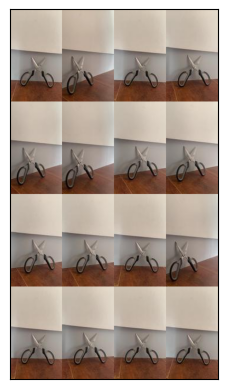

In [5]:
import matplotlib.pyplot as plt

train_imgs = imgs.numpy().reshape(4, 4, 160, 90, 3).transpose(0, 2, 1, 3, 4).reshape(4 * 160, 4 * 90, 3)

plt.figure()
plt.imshow(train_imgs)
plt.xticks([]), plt.yticks([])
plt.show()
# plt.savefig('train.png', bbox_inches = 'tight', pad_inches = -0.01, dpi = 300)

In [6]:
imgs = imgs.permute(0, 3, 1, 2).cuda()
ray_origins = ray_origins.permute(0, 3, 1, 2).cuda()
ray_directions = ray_directions.permute(0, 3, 1, 2).cuda()
model = model.cuda()

In [7]:
with torch.no_grad():
    pred, mask = model.forward(imgs, ray_origins, ray_directions)

# with torch.no_grad():
#     pred2, mask2 = model.forward(imgs, ray_origins, ray_directions)

# with torch.no_grad():
#     pred3, mask3 = model.forward(imgs, ray_origins, ray_directions)

In [8]:
print(mask.shape, pred.shape)

torch.Size([16, 90]) torch.Size([16, 90, 480])


In [9]:
patches = model.model.patchify(imgs)
recon = patches * ~mask.unsqueeze(-1).expand(-1, -1, 480).bool() + pred * mask.unsqueeze(-1).expand(-1, -1, 480).bool()

In [10]:
print(recon.shape)
import torch
recon = model.model.unpatchify(recon).cpu().permute(0, 2, 3, 1).numpy()

torch.Size([16, 90, 480])


In [11]:
pred = model.model.unpatchify(pred)

In [12]:
print(pred.shape)

torch.Size([16, 3, 160, 90])


In [13]:
pred = pred.cpu().permute(0, 2, 3, 1).numpy()
print(pred.shape)

(16, 160, 90, 3)


In [14]:
print(pred.max(), pred.min())

0.9478691 -0.045704324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


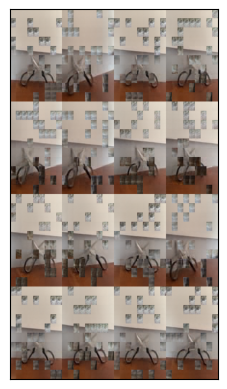

In [15]:
import matplotlib.pyplot as plt

# pred3 = model.model.unpatchify(pred3)
# pred3 = pred3.cpu().permute(0, 2, 3, 1).numpy()
plt.figure()
plt.imshow(pred.reshape(4, 4, 160, 90, 3).transpose(0, 2, 1, 3, 4).reshape(4 * 160, 4 * 90, 3))
plt.xticks([]), plt.yticks([])
plt.show()
# plt.savefig('recon_val.png', bbox_inches = 'tight', pad_inches = -0.01, dpi = 300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


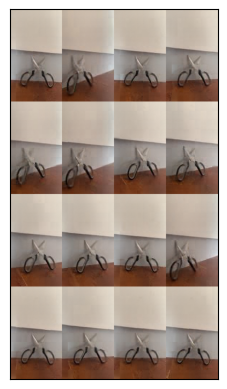

In [16]:
plt.figure()
plt.imshow(recon.reshape(4, 4, 160, 90, 3).transpose(0, 2, 1, 3, 4).reshape(4 * 160, 4 * 90, 3))
plt.xticks([]), plt.yticks([])
plt.show()
# plt.savefig('recon_mix.png', bbox_inches = 'tight', pad_inches = -0.01, dpi = 300)